## 2021Shi. mPose: Environtment-Subject agnostic 3D skeleton posture reconstruction

This notebook is devided into 5 steps:
1. import of function to display output (create video)
2. Definition of the Dataset
3. Definition of the Network, training and validation functions
4. Training Process:
5. Display results (video)

### 1: Display functions

Notice that this part should be done at the begining, cause importing numpy, or matplotlib after causes errors.

In [73]:
# 1_0010: import matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

import scipy.io
import numpy as np

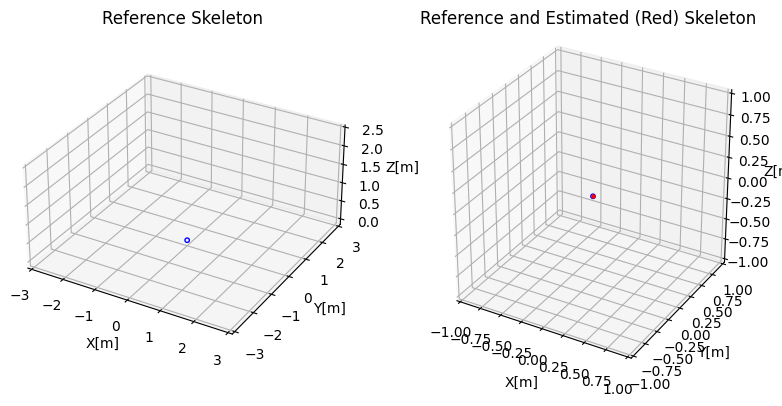

In [74]:
# 1_0020: Define fig and function to animate an skeleton
fig_skeleton = plt.figure(figsize=plt.figaspect(0.5))

# global scene
ax1 = fig_skeleton.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)
ax1.set_zlim(-0.1,2.5)
ax1.set_box_aspect([1,1,0.5])
ax1.set_xlabel('X[m]')
ax1.set_ylabel('Y[m]')
ax1.set_zlabel('Z[m]')
ax1.set_title('Reference Skeleton')


# skeleton-centered
ax2 = fig_skeleton.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_zlim(-1,1)
ax2.set_box_aspect([1,1,1])
ax2.set_xlabel('X[m]')
ax2.set_ylabel('Y[m]')
ax2.set_zlabel('Z[m]')
ax2.set_title('Reference and Estimated (Red) Skeleton')

# get handlers:
skel_glb = ax1.scatter([0],[0],[0],'.',s=10,facecolors='none', edgecolors='b')
skel_loc = ax2.scatter([0],[0],[0],'.',s=10,facecolors='none', edgecolors='b')
skel_loc_hat = ax2.scatter([0],[0],[0],'.',s=5,facecolors='r', edgecolors='r')

# function to plot the skeletons:
def plot_skeleton_over_time(t_idx, jnts_glb_true, jnts_loc_hat):
    # convert to numpy array:
    jnts_glb_true = jnts_glb_true.numpy()
    jnts_loc_hat = jnts_loc_hat.numpy()

    # -------------------------------------------
    # plot GLOBAL scene: jnts_glb_true only:
    x_glb_true = jnts_glb_true[t_idx,0,:]
    y_glb_true = jnts_glb_true[t_idx,1,:]
    z_glb_true = jnts_glb_true[t_idx,2,:]
    skel_glb._offsets3d = (x_glb_true,y_glb_true,z_glb_true)

    
    # -------------------------------------------
    # skeleto-centered: LOCAL
    #  true
    x_loc_true = x_glb_true - x_glb_true[0]
    y_loc_true = y_glb_true - y_glb_true[0]
    z_loc_true = z_glb_true - z_glb_true[0]
    skel_loc._offsets3d = (x_loc_true,y_loc_true,z_loc_true)

    # estimated:
    x_loc_hat = jnts_loc_hat[t_idx,0,:]
    y_loc_hat = jnts_loc_hat[t_idx,1,:]
    z_loc_hat = jnts_loc_hat[t_idx,2,:]

    x_loc_hat = jnts_loc_hat[t_idx,0,:] - x_loc_hat[0]
    y_loc_hat = jnts_loc_hat[t_idx,1,:] - y_loc_hat[0]
    z_loc_hat = jnts_loc_hat[t_idx,2,:] - z_loc_hat[0]

    skel_loc_hat._offsets3d = (x_loc_hat,y_loc_hat,z_loc_hat)
    
    return (skel_glb,skel_loc,skel_loc_hat,)

plt.show()

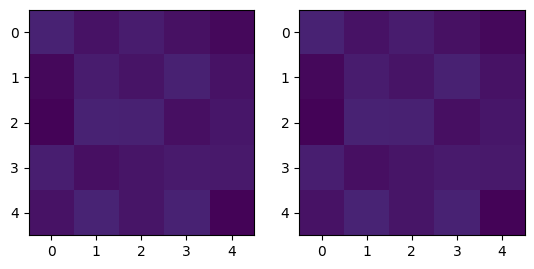

In [75]:
# 1_0030: Define fig and func to animate imput images
fig_images, (ax1, ax2) = plt.subplots(1, 2)
a=np.random.random((5,5,2))
imshow1 = ax1.imshow(a[:,:,0], vmin=0, vmax=10)
imshow2 = ax2.imshow(a[:,:,0], vmin=0, vmax=10)

# function to plot the skeletons:
def plot_images_over_time(t_idx, imgs):
    # plot skeleton A:
    imshow1.set_array(imgs[t_idx,0,:,:,])
    imshow2.set_array(imgs[t_idx,1,:,:,])

    return (imshow1,imshow2,)


### 2. Dataset Definition

In [76]:
# 2_0010: Import torch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [77]:
# 2_0020: Define dataset Class:
class RnAngDataset(Dataset):
    def __init__(self, prefix, path_images, batch_idxs, batch_size):
        self.path_images = path_images
        self.batch_idxs = batch_idxs
        self.batch_size = batch_size
        
        self.joints_xyz = []
        self.rm_azm = []
        self.rm_elm = []
        self.torso_xyz = []
        self.roi_grids = []
        for batch_id in self.batch_idxs:
            m_start = 1 + (batch_id-1)*self.batch_size
            m_end = batch_id*self.batch_size

            f_name = '/' + prefix + '_batch_' + str(m_start) + '_' + str(m_end) + '.mat'
            mat = scipy.io.loadmat(self.path_images + f_name)

            if len(self.joints_xyz) == 0:
                self.joints_xyz = mat['jnts_xyz_all']
                self.rm_azm = mat['rm_azm_all']
                self.rm_elm = mat['rm_elevm_all']
                self.torso_xyz = mat['torso_xyz_all']
                self.roi_grids = mat['roi_grids_all']
            else:
                self.joints_xyz = np.concatenate((self.joints_xyz, mat['jnts_xyz_all']),axis=2)
                self.rm_azm = np.concatenate((self.rm_azm,mat['rm_azm_all']),axis=2)
                self.rm_elm =np.concatenate((self.rm_elm,mat['rm_elevm_all']),axis=2)
                self.torso_xyz = np.concatenate((self.torso_xyz, mat['torso_xyz_all']),axis=1)
                self.roi_grids = np.concatenate((self.roi_grids, mat['roi_grids_all']),axis=3)
                

    def __getitem__(self, idx):
        rm_azm_i = self.rm_azm[:,:,idx]
        rm_elm_i = self.rm_elm[:,:,idx]
        torso_xyz_i = self.torso_xyz[:,idx]

        imgs = np.concatenate((np.expand_dims(rm_azm_i, axis=2),np.expand_dims(rm_elm_i, axis=2)), axis=2)
        roi_grids_i = self.roi_grids[:,:,:,idx]
        # imgs = np.concatenate((imgs,roi_grids_i), axis=2)
        imgs = np.moveaxis(imgs, 2, 0)

        jnts_xyz = self.joints_xyz[:,:,idx]

        return imgs, jnts_xyz, torso_xyz_i
        
    def __len__(self):
        return self.rm_azm.shape[2]

In [78]:
# 2_0030: Display a training example, as well as the skeleton.
path_images = '../0020_DataCreator_matlab/dataset/'
prefix = 'datasetwalk'
group_idxs = [1]
group_size = 4
dataset = RnAngDataset(prefix, path_images, group_idxs, group_size)
loader = DataLoader(dataset, batch_size=50, shuffle=False)

imgs , jnts_xyz, torso_xyz  = next(iter(loader))
N_frames = jnts_xyz.shape[0]

anim = animation.FuncAnimation(fig_skeleton, plot_skeleton_over_time, frames=N_frames, fargs=(jnts_xyz,jnts_xyz), interval=120, blit=False)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [79]:
# 2_0040: Display a input example
anim = animation.FuncAnimation(fig_images, plot_images_over_time, frames=N_frames, fargs=(imgs,), interval=120, blit=True)
HTML(anim.to_html5_video())

# if animation is not being displayed, ensure your browser is compatible (it may not be shown in github.)

### 3. mPose network definition

In [80]:
# 3_0010: Define mPos CNN
class mPosNet(nn.Module):
    def __init__(self, ch_1, ch_2, ch_3, kr=10, Njnts=31):
        super().__init__()
        self.Njnts = Njnts
        # define channels for layers 1,2,3:
        self.ch_1, self.ch_2, self.ch_3 = ch_1, ch_2, ch_3
        self.kr = kr

        # conv-layers:
        self.conv2d_1 = nn.Conv2d(in_channels=2, out_channels=self.ch_1, kernel_size=self.kr, stride=2)
        self.conv2d_2 = nn.Conv2d(in_channels=self.ch_1, out_channels=self.ch_2, kernel_size=self.kr, stride=2)
        self.conv2d_3 = nn.Conv2d(in_channels=self.ch_2, out_channels=self.ch_3, kernel_size=self.kr, stride=2)
        
        # batchnorm:
        self.bn1 = nn.BatchNorm2d(self.ch_1)
        self.bn2 = nn.BatchNorm2d(self.ch_2)
        self.bn3 = nn.BatchNorm2d(self.ch_3)
        
        # max-pool / dropout layers:
        self.dropout = nn.Dropout(p=0.05)

        # fully connected:
        dim_flttn = 3*3*self.ch_3
        self.fc_1 = nn.Linear(dim_flttn,10*3*self.Njnts)
        self.fc_2 = nn.Linear(10*3*self.Njnts,3*self.Njnts*3)
        self.bn_1 = nn.BatchNorm1d(10*3*self.Njnts)
        self.bn_2= nn.BatchNorm1d(3*self.Njnts*3)

        # regression:
        self.rl_1 = nn.Linear(3*self.Njnts*3,3*self.Njnts)
        
        
    def forward(self, x):
        # define the architecture:
        x = self.conv2d_1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        
        
        x = self.conv2d_2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2d_3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = torch.flatten(x,1)
        
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = F.relu(x)

        x = self.fc_2(x)
        x = self.bn_2(x)
        x = F.relu(x)

        x = self.rl_1(x)

        skel_loc_hat = x.view(-1,3,self.Njnts)      
        return skel_loc_hat

In [81]:
# 3_0020: Loss:
def loss_fn(y_true, y_hat):
    p_diff = y_true - y_hat
    p_diff_mag = torch.sqrt(torch.sum(p_diff**2,1))
    #error = p_diff**2
    #p_diff_mag = error
    return p_diff_mag.mean()

In [82]:
# 3_0030: alternative: huber loss
def huber_loss_fn(y_true, y_hat):
    delta = 0.2
    max_a = 1
    p_diff = y_true - y_hat
    p_diff[p_diff > max_a] = max_a
    a = torch.sqrt(torch.sum(p_diff**2,1))
    flg = a <= delta
    flg_not = a > delta

    Ld1 = 0.5*(a[flg]**2)
    Ld2 = delta*(a[flg_not] - 0.5*delta)

    Ld = Ld1.sum() + Ld2.sum()
    
    return Ld / (flg.shape[0]*flg.shape[1])

In [83]:
# 3_0040: Training function:
def training_epoch(train_loader, model, device, lr):
    # optimizer = optim.SGD(model.parameters(),lr=lr, weight_decay=1e-5)
    optimizer = optim.SGD(model.parameters(),lr=lr)
    model = model.to(device)
    train_loss = []
    
    for  imgs, jnts_glb_xyz, torso_xyz  in train_loader:

        # x_batch dim (batch, ch, r, az/el)
        imgs = imgs.type(torch.FloatTensor).to(device)
        jnts_loc_xyz = jnts_glb_xyz - jnts_glb_xyz[:,:,0][:,:,None]
        jnts_loc_xyz = jnts_loc_xyz.type(torch.FloatTensor).to(device)

        # train:
        model.train()
        jnts_loc_xyz_hat = model(imgs)
        

        # ------------------------------------------------------------------------
        loss = loss_fn(jnts_loc_xyz, jnts_loc_xyz_hat)
        
        # -------------------------------------------------------------------------
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    #print(train_loss)
    return sum(train_loss)/len(train_loss)


In [84]:
# 3_0050: Validation function:
def validation_epoch(validation_loader, model, device):
    model = model.to(device)
    validation_loss = []
    for img, jnts_glb_xyz, torso_xyz in validation_loader:

        # img dim (batch, ch, r, az/el)
        img = img.type(torch.FloatTensor).to(device)
        jnts_loc_xyz = jnts_glb_xyz - jnts_glb_xyz[:,:,0][:,:,None]
        jnts_loc_xyz = jnts_loc_xyz.type(torch.FloatTensor).to(device)
        

        # train:
        model.eval()
        jnts_loc_xyz_hat = model(img)
        
       # ------------------------------------------------------------------------
        val_loss = loss_fn(jnts_loc_xyz, jnts_loc_xyz_hat)
        # -------------------------------------------------------------------------
        validation_loss.append(val_loss.item())
        
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    #print(train_loss)
    return sum(validation_loss)/len(validation_loss)

### 4. Training process

In [85]:
# 4_0010: create obj-related to training: dataset, loaders, etc
# create dataset:
path_images = '../0020_DataCreator_matlab/dataset/'
prefix = 'datasetwalk'
# group_idxs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
group_idxs = [1, 2, 3, 4, 5]
group_size = 4
dataset = RnAngDataset(prefix, path_images, group_idxs, group_size)

# split dataset:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [86]:
# network:
mpos_net = mPosNet(ch_1=64, ch_2=128, ch_3=256, kr=10, Njnts=31)
loss_epoch = []
val_loss_epoch = []

In [87]:
# 4_0020: TRAIN AND VALIDATE THE MODEL

# define params of training:
n_epoch = 20
for epoch_idx in range(n_epoch):
    
    # Training phase:
    loss_epoch_i = training_epoch(train_loader, mpos_net, device, lr=1e-2)
    loss_epoch.append(loss_epoch_i)
    
    # Validation phase:
    val_loss_epoch_i = validation_epoch(val_loader, mpos_net, device)
    val_loss_epoch.append(val_loss_epoch_i)
    
    print('epoch {}, loss: {} - val-loss: {}'.format(epoch_idx, loss_epoch_i, val_loss_epoch_i))

epoch 0, loss: 0.6054689753800631 - val-loss: 0.41156793385744095
epoch 1, loss: 0.32959238315622014 - val-loss: 0.2295693519214789
epoch 2, loss: 0.23626440111547709 - val-loss: 0.17321048925320306
epoch 3, loss: 0.20370535645633936 - val-loss: 0.1573743944366773
epoch 4, loss: 0.17759994262208542 - val-loss: 0.12576348458727202
epoch 5, loss: 0.16596235055476427 - val-loss: 0.11897619130710761
epoch 6, loss: 0.16076014765227833 - val-loss: 0.11506013385951519
epoch 7, loss: 0.14932625399281582 - val-loss: 0.10342211027940114
epoch 8, loss: 0.14411882404237986 - val-loss: 0.10273091495037079
epoch 9, loss: 0.14045965500796834 - val-loss: 0.09665105181435744
epoch 10, loss: 0.13486070573950806 - val-loss: 0.09409370211263497
epoch 11, loss: 0.12829498123998442 - val-loss: 0.09267686866223812
epoch 12, loss: 0.12551761930808425 - val-loss: 0.08713817596435547
epoch 13, loss: 0.1246554081638654 - val-loss: 0.08331358867386977
epoch 14, loss: 0.12558633787557483 - val-loss: 0.085378832494

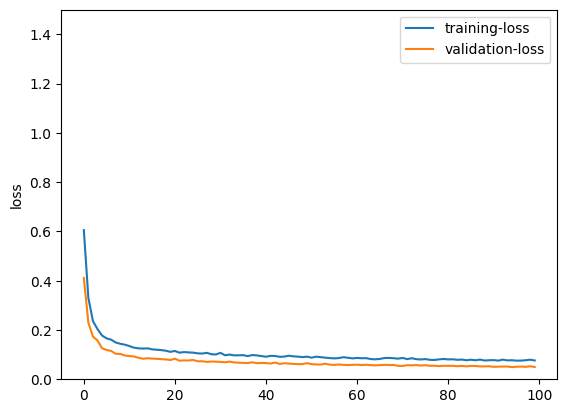

In [88]:
# 4_0030: Show the loss vs epoch:

plt.plot(list(loss_epoch),label='training-loss')
plt.plot(list(val_loss_epoch),label='validation-loss')
plt.ylabel('loss')
plt.ylim(0,1.5)
plt.legend()
plt.show()

In [89]:
test_loader = DataLoader(dataset, batch_size=200, shuffle=False)
imgs , jnts_glb_xyz, torso_xyz  = next(iter(test_loader))
imgs , jnts_glb_xyz, torso_xyz  = next(iter(test_loader))


imgs = imgs.type(torch.FloatTensor).to(device)
mpos_net.eval()
jnts_loc_xyz_hat = mpos_net(imgs)
jnts_loc_xyz_hat = jnts_loc_xyz_hat.cpu().detach()


print(jnts_glb_xyz.shape)
print(jnts_loc_xyz_hat.shape)


N_frames = jnts_glb_xyz.shape[0]
anim = animation.FuncAnimation(fig_skeleton, plot_skeleton_over_time, frames=N_frames, fargs=(jnts_glb_xyz,jnts_loc_xyz_hat),
                              interval=120, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

torch.Size([200, 3, 31])
torch.Size([200, 3, 31])


### 5. Save Load the model:

In [90]:
PATH = './'
mpos_net_fname = 'model.pt'

In [91]:
# save the model:
#torch.save(mpos_net, PATH+mpos_net_fname)


In [92]:
# load the model:
# mpos_net = torch.load(PATH + mpos_net_fname)